# Diffusion Model from Scratch in PyTorch

Based on [this](https://towardsdatascience.com/diffusion-model-from-scratch-in-pytorch-ddpm-9d9760528946) TowardsDataScience article

## Packages and Presets

In [4]:
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange 
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
from timm.utils import ModelEmaV3 
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch.optim as optim
import numpy as np
%load_ext blackcellmagic

In [16]:
# Set all seeds:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## About the Model

### Diffusion Model Training
**Input:** Training data x

**Output:** Model parameters $\phi_t$

**repeat**

> for $i\in \mathcal{B}$ do # for every training index in batch
>> $t \sim \mathcal{U}(\{1, ..., T\})$ # sample a time step

>> $\varepsilon \sim \mathcal{N}(0, I)$ # sample noise  

>> $\ell_i = \|g_t(\sqrt{\alpha_t} x_i + \sqrt{1-\alpha_t}\varepsilon\phi_t) - \varepsilon \|^2$ # individual loss

> Acucmulate loses for batch and take gradient step

**until converged**
 

### Sampling from Diffusion Model
**Input:** Model $g_t(\cdot, \phi_t)$

**Output:** Sample $x$

$z_T \sim \mathcal{N}(0, I)$ # sample last latent variable

for $t = T, ..., 2$ do
> $\hat{z}_{t-1} = \dfrac{1}{\sqrt{1-\beta_t}}z_t - \dfrac{\beta_t}{\sqrt{1-\alpha_t}\sqrt{1-\beta_t}}g_t(z_t, \phi_t)$ # predict previous latent variable

> $\varepsilon \sim \mathcal{N}(0, I)$

> $z_{t-1} = \hat{z}_{t-1} + \sqrt{\sigma_t}\varepsilon$ # add noise to previous altent variable

$x = \dfrac{1}{\sqrt{1-\beta_1}}z_1 - \dfrac{\beta_1}{\sqrt{1-\alpha_1}\sqrt{1-\alpha_1}}g_1(z_1, \phi_1)$ # sample from z1 without noise

Usually, we add back a small amount of noise to the final sample to prevent mode collapse/ keep the process stable after having subtracted the estimated noise previously.

### UNET

For predicting the noise for the diffusion reverse process, a special UNET is used that features attention in the 16x16 resolution and sinusoidal transformer embeddings in every residual block. The sinusoidal embeddings are used to encode for which time step the model is trying to predict the noise.

## UNET Implementation

### Sinusoidal Positional Encoding

In [2]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        # scaling factor for the sinusoidal embeddings
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        # sin for evend indices
        embeddings[:, 0::2] = torch.sin(position * div)
        # cos for odd indices
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None, None]

### Residual Block

In [35]:
class ResidualBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float) -> None:
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p = dropout_prob, inplace=True)
    
    def forward(self, x: torch.Tensor, embeddings: torch.Tensor)->torch.Tensor:
        # add positional embeddings to the input
        x = x + embeddings[:, :x.shape[1], :, :]
        # output of the residual block
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return x + r # add the residual to the input

### Attention Mechanism

In [41]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads: int, dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C * 3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, "b c h w -> b (h w ) c")
        x = self.proj1(x)
        x = rearrange(x, "b L (C H K) -> K b H L C", K=3, H=self.num_heads)
        q, k, v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(
            q, k, v, dropout_p=self.dropout_prob, is_causal=False
        )
        x = rearrange(x, "b H (h w) C -> b h w (C H)", h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, "b h w C -> b C h w")

### UNET Layer

In [37]:
class UNETLayer(nn.Module):
    def __init__(
        self,
        upscale: bool,
        attention: bool,
        num_groups: int,
        dropout_prob: float,
        num_heads: int,
        C: int,
    )-> None:
        super().__init__()
        self.resblock1 = ResidualBlock(C, num_groups, dropout_prob)
        self.resblock2 = ResidualBlock(C, num_groups, dropout_prob)

        if upscale:
            self.conv = nn.ConvTranspose2d(
                C, C // 2, kernel_size=4, stride=2, padding=1
            )
        else:
            self.conv = nn.Conv2d(C, C * 2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention = Attention(C, num_heads, dropout_prob)

    def forward(self, x: torch.Tensor, embeddings: torch.Tensor) -> torch.Tensor:
        x = self.resblock1(x, embeddings)
        if hasattr(self, "attention"):
            x = self.attention(x)
        x = self.resblock2(x, embeddings)
        return self.conv(x), x

### UNET

In [32]:
class UNET(nn.Module):
    def __init__(
        self,
        Channels: List = [64, 128, 256, 512, 512, 384],
        Attentions: List = [False, True, False, False, False, True],
        Upscales: List = [False, False, False, True, True, True],
        num_groups: int = 32,
        dropout_prob: float = 0.1,
        num_heads: int = 8,
        input_channels: int = 1,
        output_channels: int = 1,
        time_steps: int = 1000,
    ) -> None:
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(
            input_channels, Channels[0], kernel_size=3, padding=1
        )
        out_channels = (Channels[-1] // 2) + Channels[0]
        self.late_conv = nn.Conv2d(
            out_channels, out_channels // 2, kernel_size=3, padding=1
        )
        self.output_conv = nn.Conv2d(out_channels // 2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(
            time_steps=time_steps, embed_dim=max(Channels)
        )
        for i in range(self.num_layers):
            layer = UNETLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads,
            )
            setattr(self, f"Layer{i+1}", layer)

    def forward(self, x: torch.Tensor, t: int) -> torch.Tensor:
        x = self.shallow_conv(x)
        residuals = []

        # downsample
        for i in range(self.num_layers // 2):
            layer = getattr(self, f"Layer{i+1}")
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)

        # upsample
        for i in range(self.num_layers // 2, self.num_layers):
            layer = getattr(self, f"Layer{i+1}")
            x = torch.concat((layer(x, embeddings)[0], residuals.pop()), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

## Diffusion Scheduler

In [22]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int = 1000) -> None:
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t: int) -> torch.Tensor:
        return self.beta[t], self.alpha[t]

## Training

In [46]:
def train(batch_size: int=64,
          num_time_steps: int=1000,
          num_epochs: int=15,
          seed: int=-1,
          ema_decay: float=0.9999,  
          lr=2e-5,
          checkpoint_path: str=None):
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)

    train_dataset = datasets.MNIST(root='./data', train=True, download=True,transform=transforms.ToTensor())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = torch.compile(UNET()).cuda()
        
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    criterion = nn.MSELoss(reduction='mean')

    for i in range(num_epochs):
        total_loss = 0
        for bidx, (x,_) in enumerate(tqdm(train_loader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.cuda()
            x = F.pad(x, (2,2,2,2))
            t = torch.randint(0,num_time_steps,(batch_size,))
            e = torch.randn_like(x, requires_grad=False)
            a = scheduler.alpha[t].view(batch_size,1,1,1).cuda()
            x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*e)
            output = model(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
        print(f'Epoch {i+1} | Loss {total_loss / (60000/batch_size):.5f}')

    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'ema': ema.state_dict()
    }
    return checkpoint   

In [48]:
def display_reverse(images: List):
    fig, axes = plt.subplots(1, 10, figsize=(10,1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x)
        ax.axis('off')
    plt.show()

def inference(checkpoint_path: str=None,
              num_time_steps: int=1000,
              ema_decay: float=0.9999, ):
    checkpoint = torch.load(checkpoint_path)
    model = torch.compile(UNET()).cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(10):
            z = torch.randn(1, 1, 32, 32)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/( (torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t])) ))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.cuda(),t).cpu())
                if t[0] in times:
                    images.append(z)
                e = torch.randn(1, 1, 32, 32)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.cuda(),[0]).cpu())

            images.append(x)
            x = rearrange(x.squeeze(0), 'c h w -> h w c').detach()
            x = x.numpy()
            plt.imshow(x)
            plt.show()
            display_reverse(images)
            images = []

In [ ]:
def main():
    checkpoint = train(checkpoint_path=None, lr=2e-5, num_epochs=25)
    torch.save(checkpoint, 'checkpoints/ddpm_checkpoint')
    inference('checkpoints/ddpm_checkpoint')
    

if __name__ == '__main__':
    main()

W0922 18:47:56.232000 140242610791552 torch/_dynamo/convert_frame.py:357] torch._dynamo hit config.cache_size_limit (8)
W0922 18:47:56.232000 140242610791552 torch/_dynamo/convert_frame.py:357]    function: 'forward' (/tmp/ipykernel_95132/690482622.py:39)
W0922 18:47:56.232000 140242610791552 torch/_dynamo/convert_frame.py:357]    last reason: L['t'][0] == 999                                            
W0922 18:47:56.232000 140242610791552 torch/_dynamo/convert_frame.py:357] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0922 18:47:56.232000 140242610791552 torch/_dynamo/convert_frame.py:357] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.
W0922 18:48:22.690000 140242610791552 torch/_dynamo/convert_frame.py:357] torch._dynamo hit config.cache_size_limit (8)
W0922 18:48:22.690000 140242610791552 torch/_dynamo/convert_frame.py:357]    function: 'forward' (/tmp/ipykernel_95132/3784007909.py:11)
W0922 18:48:22.690000 140

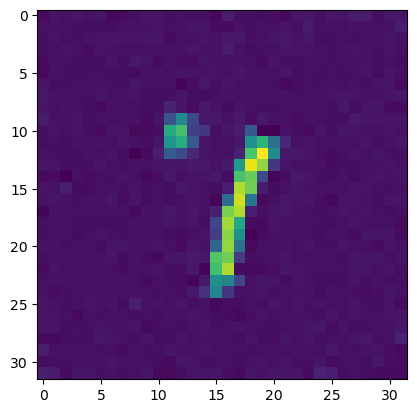

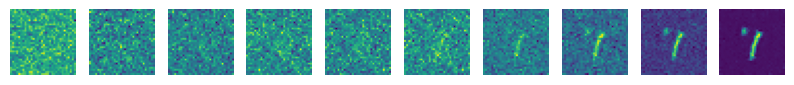

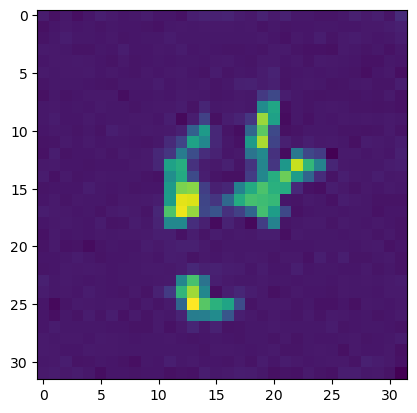

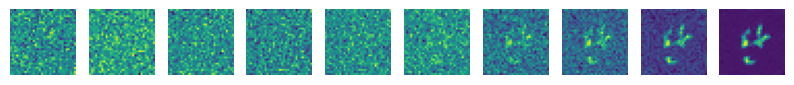

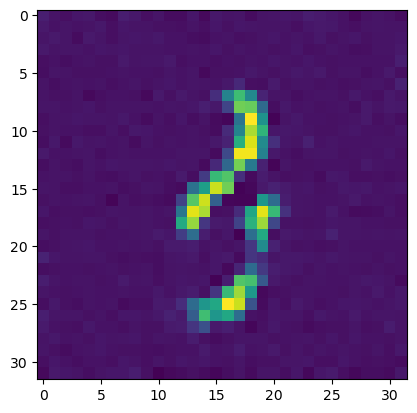

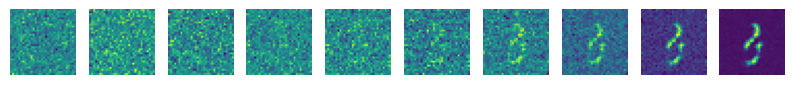

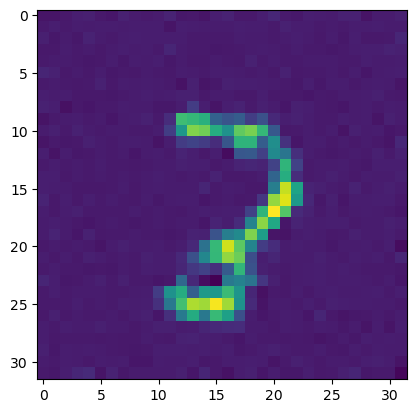

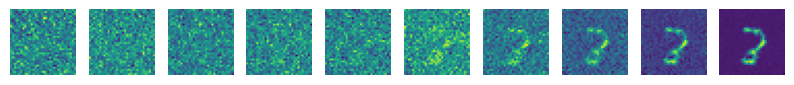

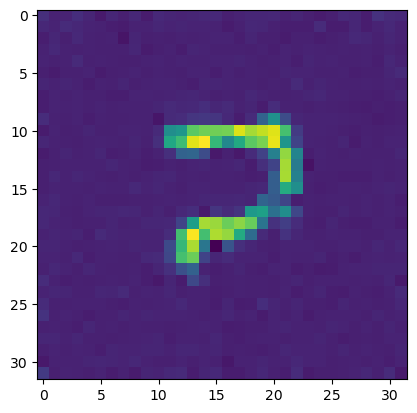

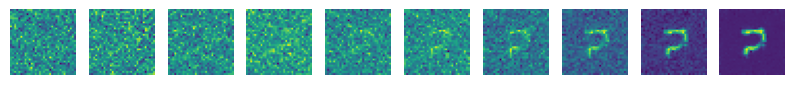

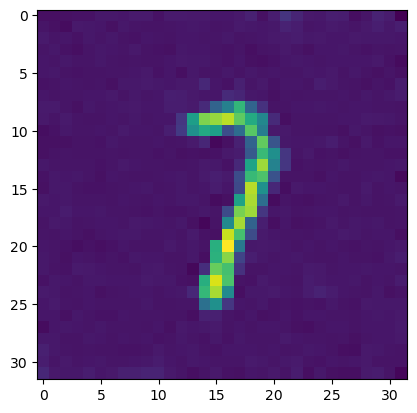

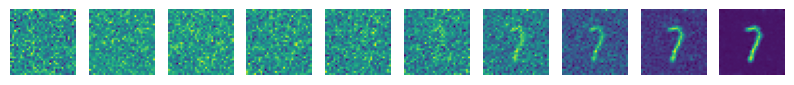

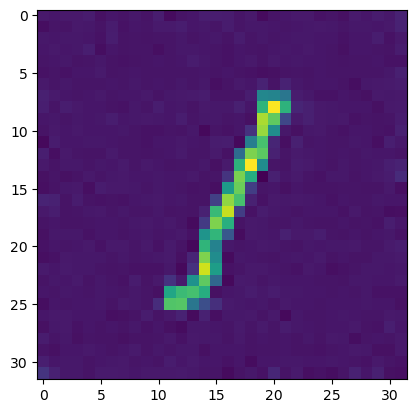

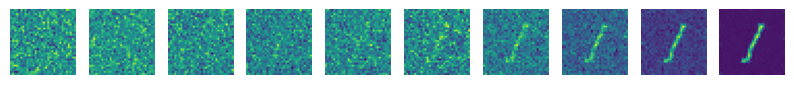

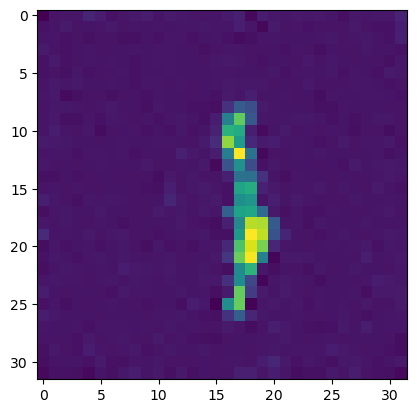

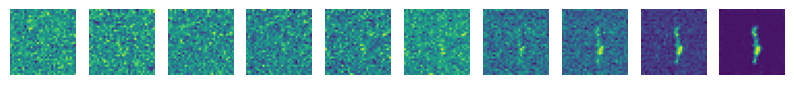

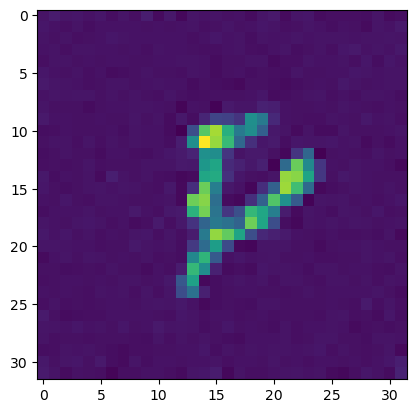

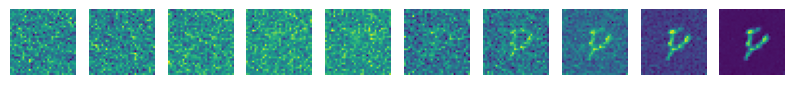

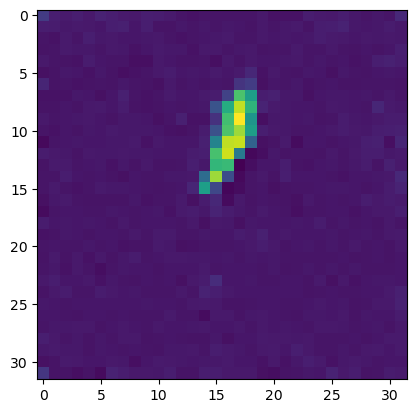

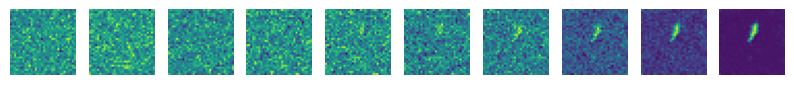

In [49]:
inference('checkpoints/ddpm_checkpoint')